In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import copy
import pylab
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [84]:
#####################################

def load_yelp():
    # Load a csv of floats:
    X = np.genfromtxt("upvote_data.csv", delimiter=",")
    # Load a text file of integers:
    y = np.loadtxt("upvote_labels.txt", dtype=np.int)
    # Load a text file of strings:
    featureNames = open("upvote_features.txt").read().splitlines()
    
    # demean!
    X = pylab.demean(X,axis=0)
    y = pylab.demean(y)
    return X,y,featureNames

def split(data,labels):
    n_train = 4000
    n_valid = 1000
    n_test = 1000
    
    train_d = data[0:n_train,:]
    train_l = labels[0:n_train]
    
    valid_d = data[n_train:n_train+n_valid,:]
    valid_l = labels[n_train:n_train+n_valid]
    
    test_d = data[n_valid::,:]
    test_l = labels[n_valid::]
    
    return train_d,valid_d,test_d,train_l,valid_l,test_l

### lasso!

def lambda_max_func(x,y):
    k = np.shape(x)[1]
    n = np.shape(x)[0]
    lambda_vec = []
    sum_y = (1/n)*np.sum(y[:])
    k_range = np.arange(k)
    lambda_max = np.max([2*np.abs(np.dot(x[:,k_ind].T,(y-sum_y))) for k_ind in k_range])
    return lambda_max

def lasso_CD(x,y,lambda_val,w_init):
    ### initialize conditions 
    delta = 1e-3
    n = np.shape(x)[0]
    d = np.shape(x)[1]

    stop_cond = 100
    w = w_init
    a = np.zeros((d,))
    c = np.zeros((d,))
    stop_cond_vec = []
    w_old = np.zeros((d,))

    while(stop_cond>delta):
        diff_y_x = y - np.dot(x,w)
        w_0 = (1/n)*np.sum(diff_y_x)

        for k in np.arange(d):
            a[k] = 2*np.dot(x[:,k].T,x[:,k])

            # subtract version
            
            diff_y_x_w0 = y - w_0 - np.dot(x,w) + np.dot(x[:,k],w[k])
            
            # bool version
#             mask = np.ones(d,dtype=bool)
#             mask[k] = 0
#             x_temp = x[:,mask]
#             w_temp = w[mask]

#             diff_y_x_w0 = y - w_0 - np.dot(x_temp,w_temp)
            
            c[k] = 2*np.dot(x[:,k].T,diff_y_x_w0)

            if c[k] < - lambda_val:
                w[k] = ((c[k]+lambda_val))/a[k]
            elif (-lambda_val < c[k] < lambda_val):
                w[k] = 0
            elif c[k] > lambda_val:
                w[k] = ((c[k]-lambda_val))/a[k]

        weight_diff = w - w_old
        w_old = np.array(w)
        
        # use maximum of weight difference 
        #stop_cond = np.max(weight_diff)
        
        # use mean weight difference 
        
        stop_cond = np.abs(np.mean(weight_diff))
        print('value of lasso run {}'.format(stop_cond))
        #stop_cond_vec.append(stop_cond)
    
    return w

def lasso_loop(x_t,y_t,x_v,y_v):
    w_vec = []
    num_non_zero_vec = []
    lambda_val = lambda_max_func(x_t,y_t)
    lambda_vec = []
    valid_error_vec=[]
    train_error_vec = []
    valid_error_diff = 100
    valid_error_old = 100
    #valid_error_delta = 1e-2
    valid_error_delta = 1e-3

    lambda_ratio = 3/5

    w_init = np.random.random(np.shape(x_t)[1])
    
    while (lambda_val>1e-1):

    #while (valid_error_diff>valid_error_delta):
        print('the value of lambda is {}'.format(lambda_val))
        w = lasso_CD(x_t,y_t,lambda_val,w_init)
        
        # total non zero 
        num_non_zero = sum((np.abs(x)>0 for x in w))
        
        w_vec.append(w)

        w_init = np.array(w)
        
        train_error = error_calc(x_t,y_t,w)
        valid_error = error_calc(x_v,y_v,w)
        
        num_non_zero_vec.append(num_non_zero)
        lambda_vec.append(lambda_val)
        lambda_val = lambda_val*lambda_ratio

        train_error_vec.append(train_error)
        valid_error_vec.append(valid_error)
        valid_error_diff = np.abs(valid_error - valid_error_old)
        valid_error_old = copy.copy(valid_error)
        print('The train error was {}'.format(train_error))

        print('The validation error was {}'.format(valid_error))
        print('The validation error difference was {}'.format(valid_error_diff))
    
    return w_vec,num_non_zero_vec,lambda_vec,valid_error_vec,train_error_vec

def error_calc(x,y,w):
    n = np.shape(y)[0]
    error = (1/n)*np.sum((y-np.dot(x,w))**2)
    return error

def plot_valid_train(train_error_vec,valid_error_vec,num_non_zero_vec,lambda_vec):
   
    ax1= plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(lambda_vec,train_error_vec,label='training error')
    plt.plot(lambda_vec,valid_error_vec,label='validation error')
    plt.xlabel(r'$ \lambda $')
    plt.title('Training and Validation error for' +'\n' +'various values of Lambda ')
    plt.ylabel('error')
    plt.legend()
    plt.savefig('hw2_valid_train_error_kaggle_noYmean_noOutlier.png')

    ax2 = plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(lambda_vec,num_non_zero_vec)
    plt.xlabel(r'$ \lambda $')
    plt.ylabel('Number of non zero entries')
    plt.title('Number of non zero entries for ' + '\n' + 'various values of lambda')
    plt.savefig('hw2_nonzero_kaggle_noYmean_noOutlier.png')
    
def plot_lasso(w,stop_cond_vec,w_star):
    ax1 = sns.distplot(w, rug=True,hist=True,bins=100, kde=False, rug_kws={"color": "g"},hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})

    plt.figure()
    ax3 = plt.bar(np.arange(len(w_star)),w_star,label='w*')
    ax2 = plt.bar(np.arange(len(w)),1.1*w,label='computed weight matrix')
    plt.legend()
    plt.ylim([-10,10])

    plt.figure()
    ax3 = plt.plot(np.arange(len(stop_cond_vec)),stop_cond_vec)
    plt.ylim([0,0.05])

### part a

In [60]:
# load data
X,y,featureNames = load_yelp()

# split data
train_d,valid_d,test_d,train_l,valid_l,test_l = split(X,y)


In [61]:
# np.shape(train_d)
# outliers = (np.max(np.abs(train_d),axis=0))
# plt.hist(outliers)
# outliers[622]

# np.shape(train_d)
# ind_outlier = np.argmax(np.max(np.abs(train_d),axis=1))
# np.shape(np.max(np.abs(train_d),axis=1))
# mask_good = np.ones((np.shape(train_d)[0],),dtype=bool)
# mask_good[ind_outlier] = False
# print('mask shape is ' + str(np.shape(mask_good)))
# train_d_noOutlier = np.array(train_d[mask_good,:])
# train_l_noOutlier = np.array(train_l[mask_good])
# outliers_noOutlier = (np.max(np.abs(train_d_noOutlier),axis=1))
# np.shape(outliers_noOutlier)
# plt.figure()
# plt.hist(outliers_noOutlier)


(4000, 1000)

(4000,)

(3990,)

(array([ 2339.,  1010.,   346.,   157.,    71.,    34.,    10.,    13.,
            7.,     3.]),
 array([ 0.02236456,  0.06493859,  0.10751261,  0.15008664,  0.19266066,
         0.23523469,  0.27780871,  0.32038274,  0.36295676,  0.40553079,
         0.44810481]),
 <a list of 10 Patch objects>)

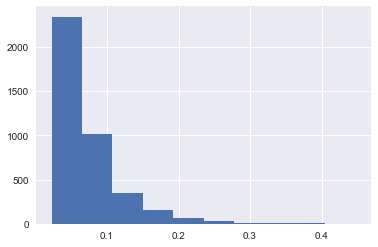

In [72]:
np.shape(train_d)
#ind_outlier = np.argmax(np.max(np.abs(train_d),axis=1))
ind_outlier = np.argpartition(np.max(np.abs(train_d),axis=1),-10)[-10:]
mask_good = np.ones((np.shape(train_d)[0],),dtype=bool)
mask_good[ind_outlier] = False
np.shape(mask_good)
train_d_noOut = train_d[mask_good,:]
train_l_noOut = train_l[mask_good]
outliers_noOutlier = (np.max(np.abs(train_d_noOut),axis=1))
np.shape(outliers_noOutlier)
plt.figure()
plt.hist(outliers_noOutlier)


In [73]:
ind2 = np.argmax(np.max(np.abs(train_d_noOut),axis=1))
np.max(train_d_noOut[ind2,:])

np.max(train_d[ind_outlier,:])

0.44810481282166664

0.73003499765000002

In [80]:
np.shape(train_d_noOut)
np.shape(train_l_noOut)

(3990, 1000)

(3990,)

In [78]:
#w_vec,num_non_zero_vec,lambda_vec,valid_error_vec,train_error_vec = lasso_loop(train_d,train_l,valid_d,valid_l)

w_vec,num_non_zero_vec,lambda_vec,valid_error_vec,train_error_vec = lasso_loop(train_d_noOut,train_l_noOut,valid_d,valid_l)

the value of lambda is 137.5105600932961
value of lasso run 0.10847152579326169
value of lasso run 0.08613406331734384
value of lasso run 0.022337462475917863
value of lasso run 0.0
The validation error was 5.272048027777779
The validation error difference was 94.72795197222221
the value of lambda is 82.50633605597766
value of lasso run 0.04953170520835519
value of lasso run 0.00463959321246083
value of lasso run 0.0008544470188529369
The validation error was 3.613140048366497
The validation error difference was 1.658907979411282
the value of lambda is 49.50380163358659
value of lasso run 0.0739799281762451
value of lasso run 0.00270500310883952
value of lasso run 0.0005319688245157658
The validation error was 3.0010489407135403
The validation error difference was 0.6120911076529567
the value of lambda is 29.702280980151954
value of lasso run 0.09428294620584031
value of lasso run 0.002681278599428647
value of lasso run 0.001867544447615825
value of lasso run 0.0003181586534158475
The 

value of lasso run 0.0010596350599424435
value of lasso run 0.001071195427751674
value of lasso run 0.0010727234048406643
value of lasso run 0.0010706163048886204
value of lasso run 0.0010625158914757313
value of lasso run 0.0010350529413494524
value of lasso run 0.001039023177835527
value of lasso run 0.0010379580230930328
value of lasso run 0.0010383614862535802
value of lasso run 0.0010381327089409233
value of lasso run 0.0010541074073437278
value of lasso run 0.00104370562391692
value of lasso run 0.0010421916463679457
value of lasso run 0.0010430374567729018
value of lasso run 0.0010435482815351362
value of lasso run 0.0010446306740232727
value of lasso run 0.0010519922963478725
value of lasso run 0.0010492606286504789
value of lasso run 0.0010496600874699892
value of lasso run 0.0010390267594753391
value of lasso run 0.0010396131014439396
value of lasso run 0.0010379481380968965
value of lasso run 0.0010365557002583738
value of lasso run 0.001034304698232283
value of lasso run 0.

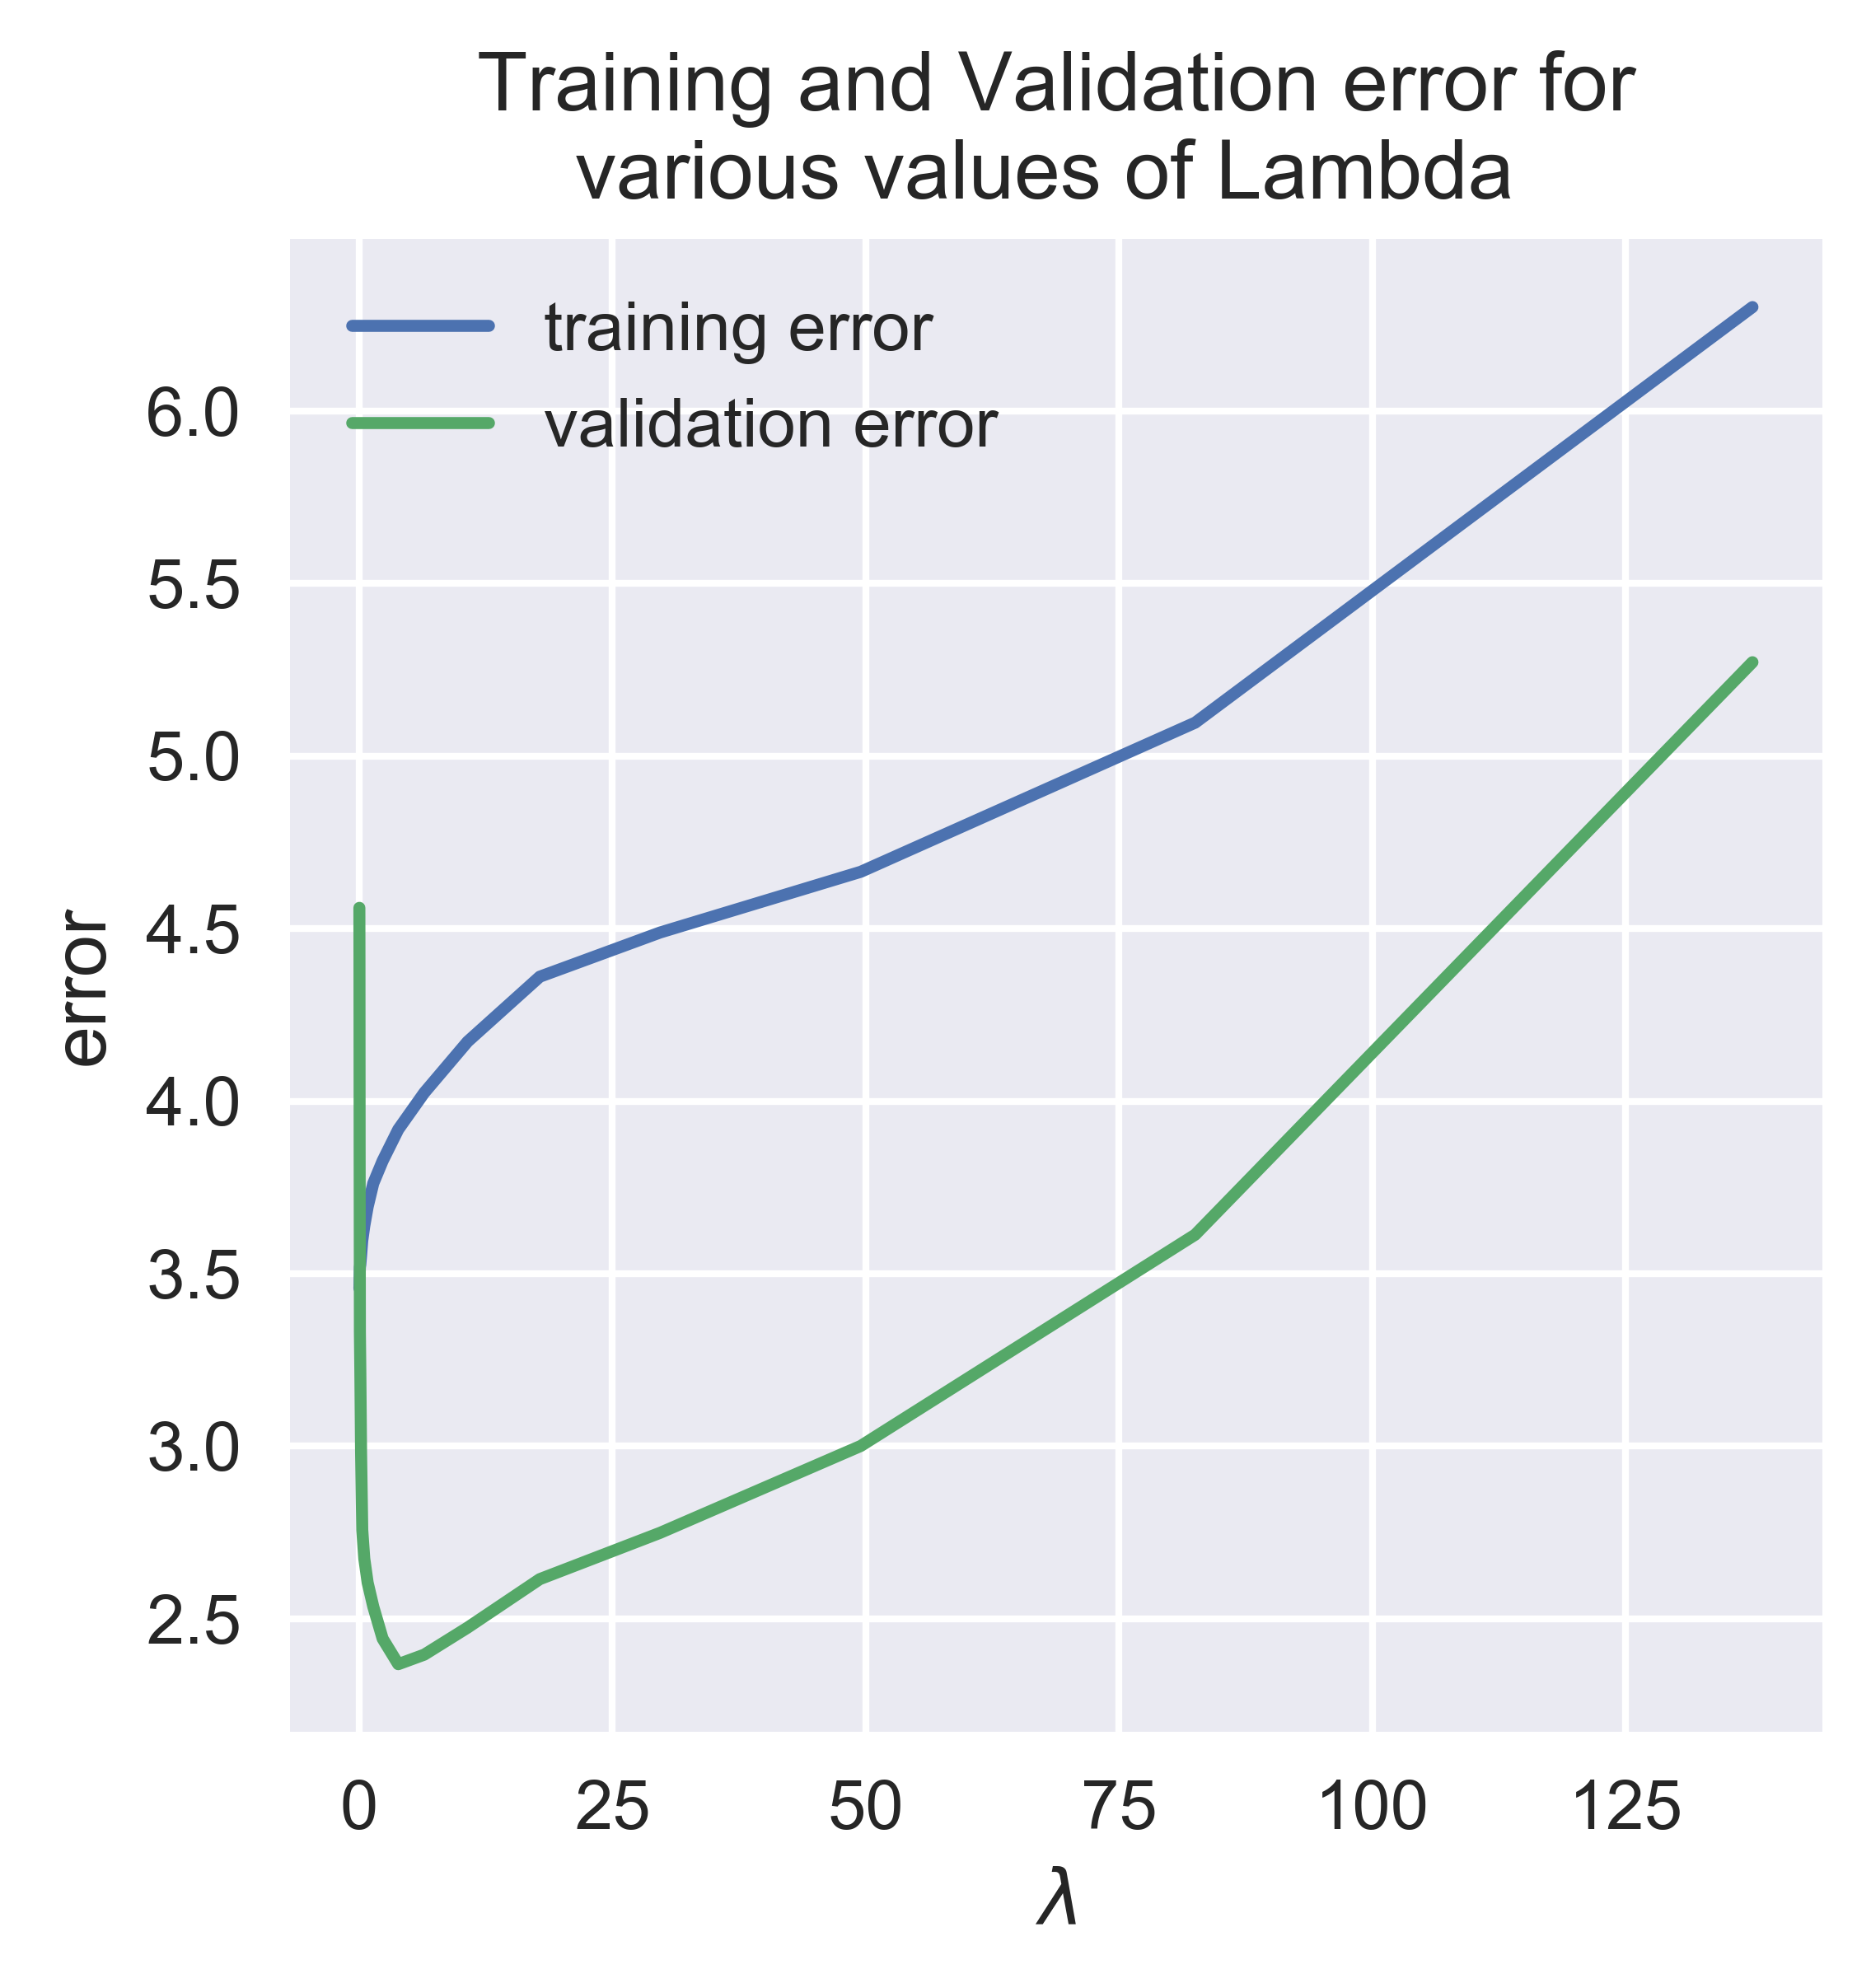

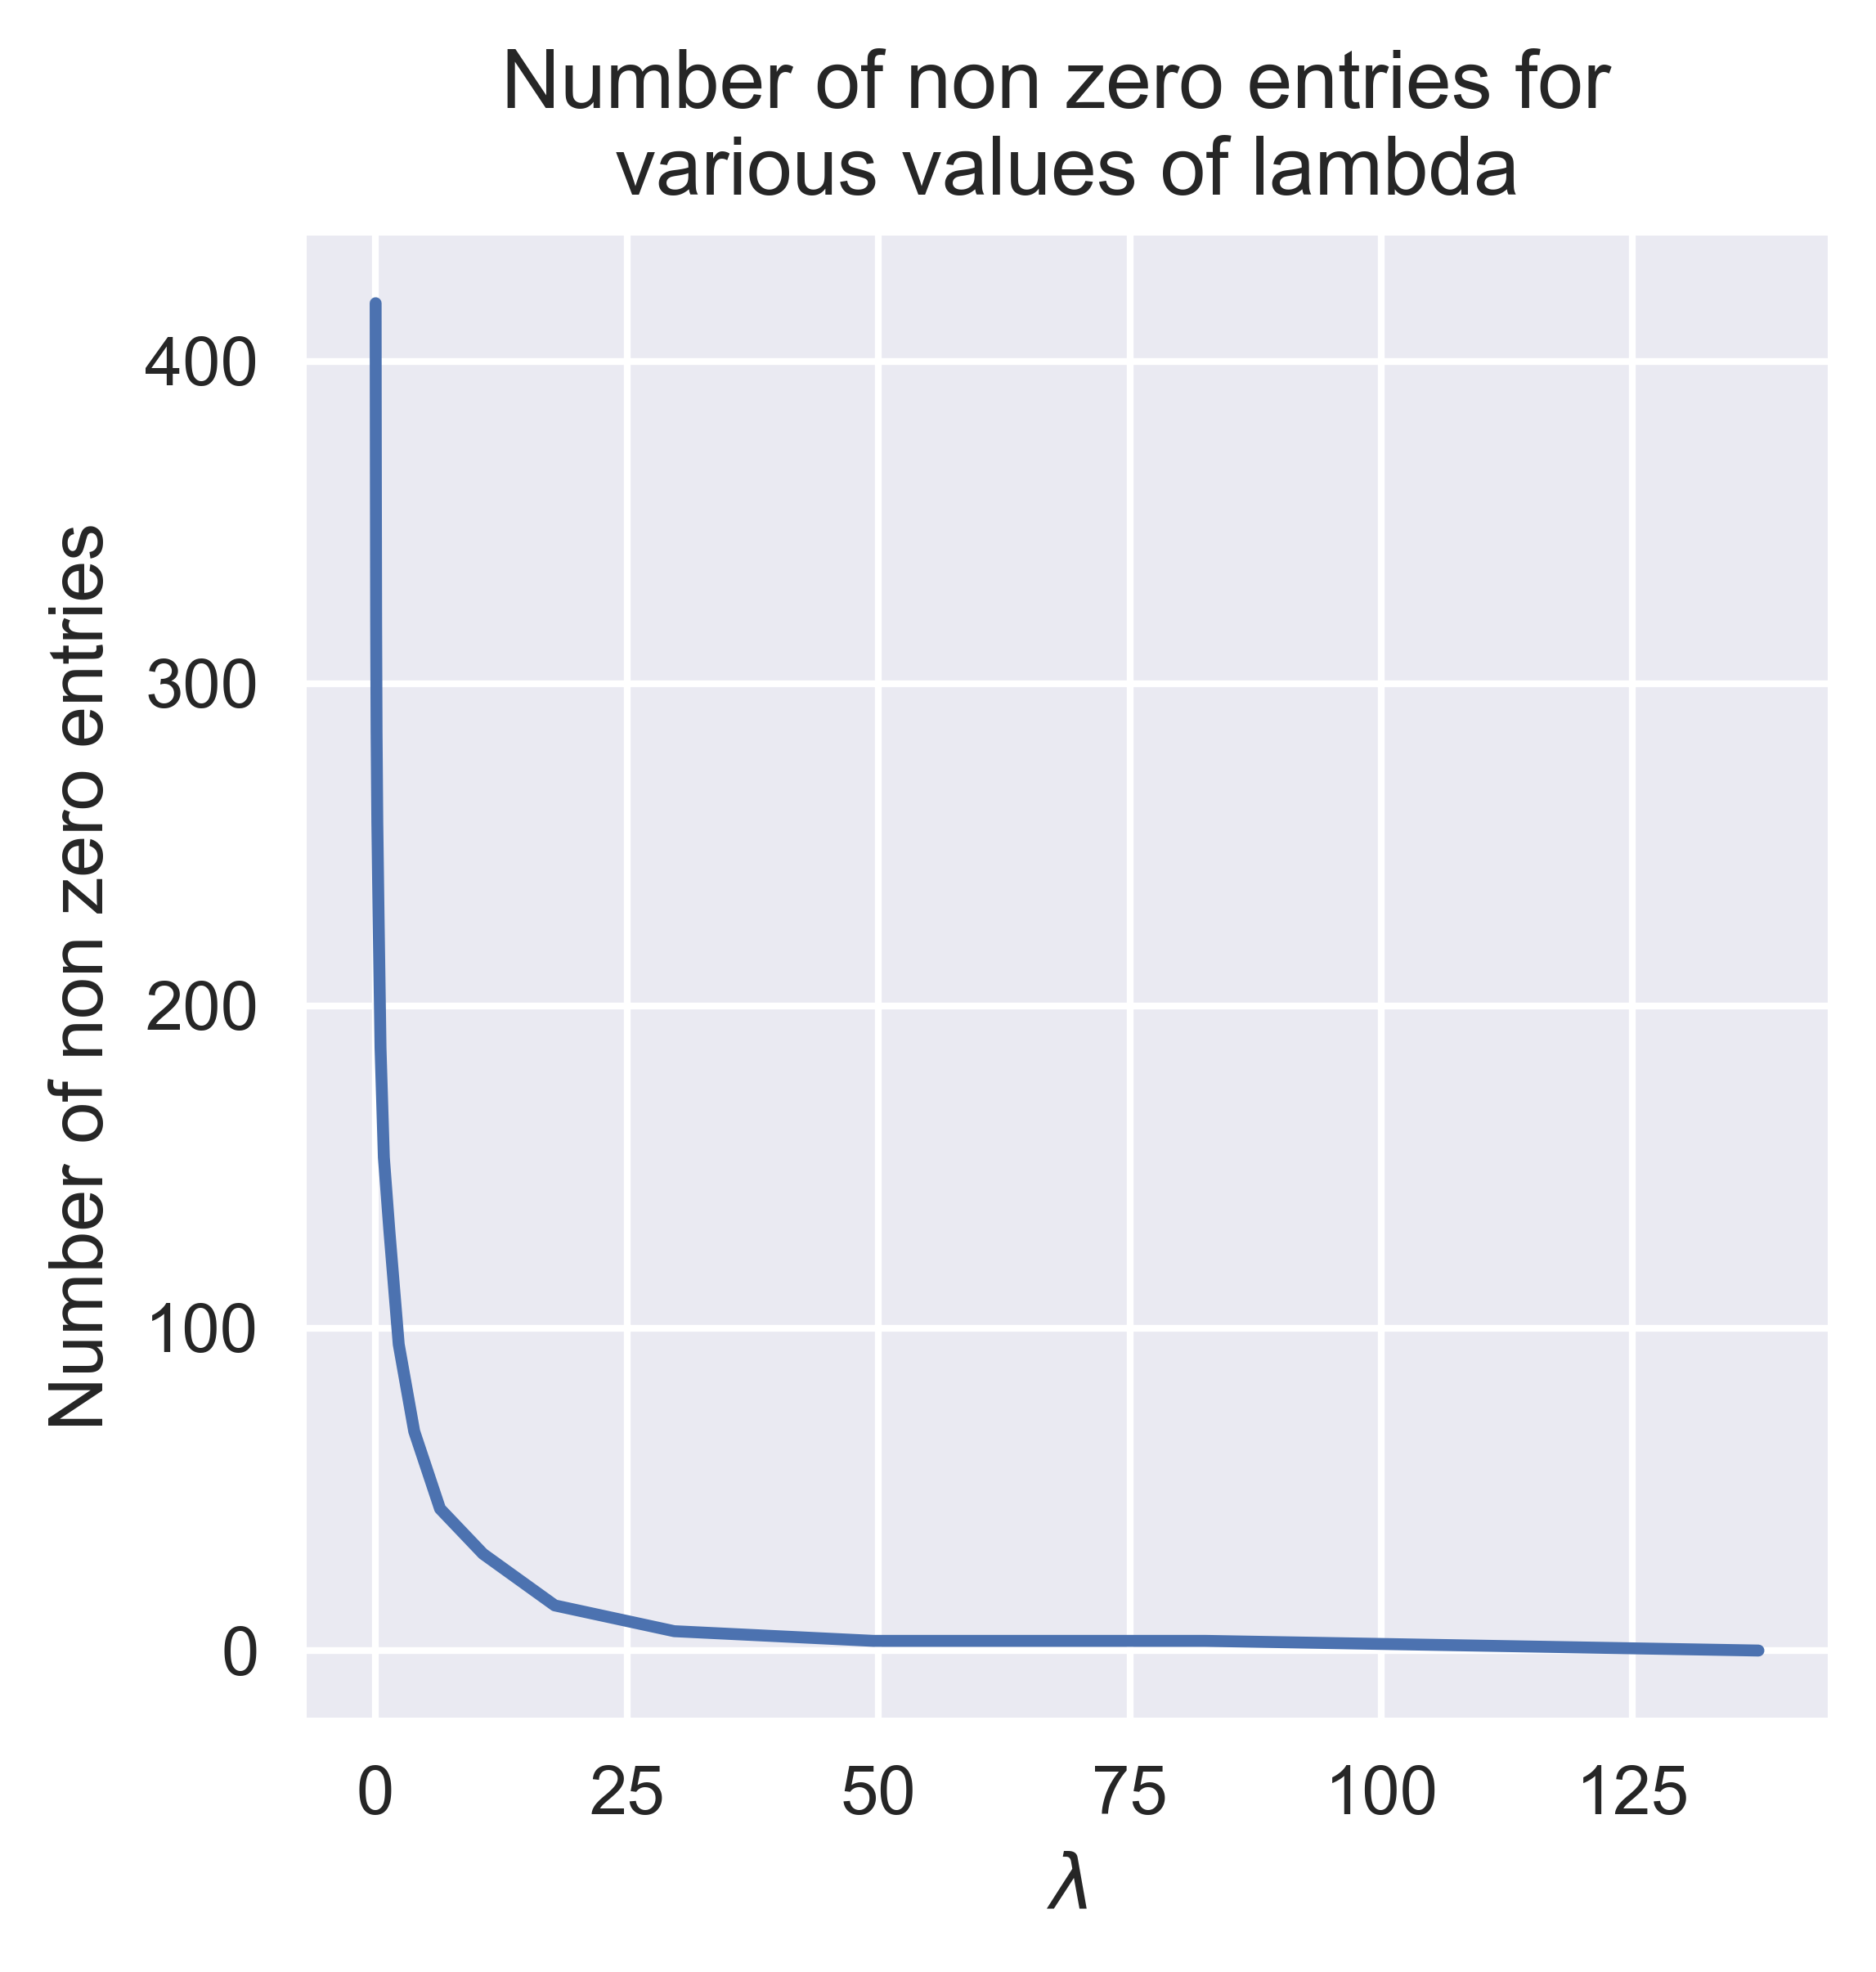

In [79]:
plot_valid_train(train_error_vec,valid_error_vec,num_non_zero_vec,lambda_vec)

In [27]:
np.shape(train_l)

(3999,)

### part b

In [81]:
# lambda optimal
ind_valid_min = np.array(np.argmin(valid_error_vec))
lambda_opt = lambda_vec[ind_valid_min]
w_vec_array = np.array(w_vec)
w_best = w_vec_array[ind_valid_min,:]

test_error = error_calc(test_d,test_l,w_best)
print('The test error is {}'.format(test_error))

ind_valid_min
np.shape(ind_valid_min)
np.shape(w_vec)
type(ind_valid_min)
type(w_vec)

The test error is 4.158213898713127


array(7, dtype=int64)

()

(19, 1000)

numpy.ndarray

list

### part c

In [82]:
featureNamesArray = np.array(featureNames)

In [83]:
inds_top10 = np.argpartition(w_best, -10)[-10:]

top10_weight = w_best[inds_top10]
top10_feat = featureNamesArray[inds_top10]
zipped_top10 = list(zip(top10_feat,top10_weight))

print('The top ten features and their weights are {}'.format(zipped_top10))

The top ten features and their weights are [('UserFunnyVotes*IsShopping', 7.9473202092453512), ('log(ReviewNumCharacters*UserUsefulVotes)', 8.7647558212620567), ('ReviewNumCharacters*ReviewNumLineBreaks', 9.969202236836864), ('BusinessNumReviews*InGlendale', 10.948629161767625), ('ReviewInFall*InGlendale', 12.526577564626679), ('sqrt(ReviewNumCharacters*UserFunnyVotes)', 49.042578276634487), ('sqrt(UserCoolVotes*BusinessNumStars)', 15.85124433689132), ('sqrt(UserFunnyVotes*InPhoenix)', 15.927456102152151), ('UserUsefulVotes*InScottsdale', 16.408321703529296), ('sqrt(ReviewNumCharacters*UserCoolVotes)', 24.178892936118199)]


### scratch section

In [15]:
lambda_opt

4.0849925542867975